# ライブラリの読み込み

In [1]:
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import igraph
import seaborn as sns
%matplotlib inline

ユニバースの情報を取得

In [2]:
df_univ = pd.read_excel("df_univ.xlsx")
df_univ

,CODE,NAME,IND33,IND33_NAME,SIZE_CODE,SIZE,MCAP
0,1301,極洋,50,水産・農林業,7,TOPIX Small 2,251.484793
1,1332,ニッスイ,50,水産・農林業,4,TOPIX Mid400,201.030688
2,1333,マルハニチロ,50,水産・農林業,4,TOPIX Mid400,237.240221
3,1375,雪国まいたけ,50,水産・農林業,7,TOPIX Small 2,25.935481
4,1376,カネコ種苗,50,水産・農林業,7,TOPIX Small 2,105.799271
...,...,...,...,...,...,...,...
2158,9991,ジェコス,6050,卸売業,7,TOPIX Small 2,0.503773
2159,9993,ヤマザワ,6100,小売業,7,TOPIX Small 2,94.119841
2160,9994,やまや,6100,小売業,7,TOPIX Small 2,47.934445
2161,9995,グローセル,6050,卸売業,7,TOPIX Small 2,645.209535


株式保有状況を適当に生成

In [3]:
num_stock_average = 10
df_x_to_y = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).rename(columns = {"CODE": "CODE_X"})
df_x_to_y["CODE_Y"] = df_univ[["CODE"]].sample(n = num_stock_average * len(df_univ), replace = True).values
df_x_to_y = df_x_to_y[df_x_to_y["CODE_X"] != df_x_to_y["CODE_Y"]].copy()
alpha, beta = 1.0, 10.0
df_x_to_y["RATIO_X_TO_Y"] = np.random.beta(alpha, beta, size = len(df_x_to_y))
df_x_to_y["MCAP_X_TO_Y"] = np.random.lognormal(mean = 3, sigma = 1, size = len(df_x_to_y))

df_x_to_y.reset_index(drop = True)

,CODE_X,CODE_Y,RATIO_X_TO_Y,MCAP_X_TO_Y
0,8219,2664,0.183339,33.967034
1,9278,6305,0.044270,20.678550
2,2163,9983,0.118775,10.000098
3,1882,9991,0.319297,10.696333
4,2120,3004,0.158377,16.322699
...,...,...,...,...
21616,1898,6507,0.026073,16.202586
21617,4531,6390,0.028561,24.094363
21618,7916,4994,0.062041,82.520030
21619,7590,6727,0.005217,5.868535


グラフを作成

In [4]:
G = nx.from_pandas_edgelist(df_x_to_y, source = "CODE_X", target = "CODE_Y",\
                            edge_attr = ["RATIO_X_TO_Y", "MCAP_X_TO_Y"], create_using = nx.DiGraph)
df_univ["COLOR"] = "white"
dict_node_attr = df_univ.set_index('CODE').to_dict('index')
nx.set_node_attributes(G, dict_node_attr)

# グラフのプロット

ある企業に注目した場合

In [5]:
CODE_FOCUS = 7203

# 関数内で処理すると時間がかかってしまう
G_undirected = G.to_undirected()
G_undirected_reciprocal = G.to_undirected(reciprocal = True)

# 着目する企業から(方向を考慮しない)距離がdistance以内である企業を(持ち合い以外の場合も)抽出
def filter_neighbors(node):
    distance = 1
    return (nx.shortest_path_length(G_undirected, source = CODE_FOCUS, target = node) <= distance)

# 上記の中で，持ち合いである場合のみ抽出
def filter_reciprocal_neighbors(node):
    distance = 1
    return (nx.shortest_path_length(G_undirected_reciprocal, source = CODE_FOCUS, target = node) <= distance)

# 持ち合いであるエッジのみを表示
def filter_reciprocal_edge(node1, node2):
    return (nx.is_weighted(G, (node1, node2)) & nx.is_weighted(G, (node2, node1)))

G_focus = nx.subgraph_view(G, filter_node = filter_neighbors)
nx.set_node_attributes(G_focus, name = "COLOR", values = {CODE_FOCUS: "red"})

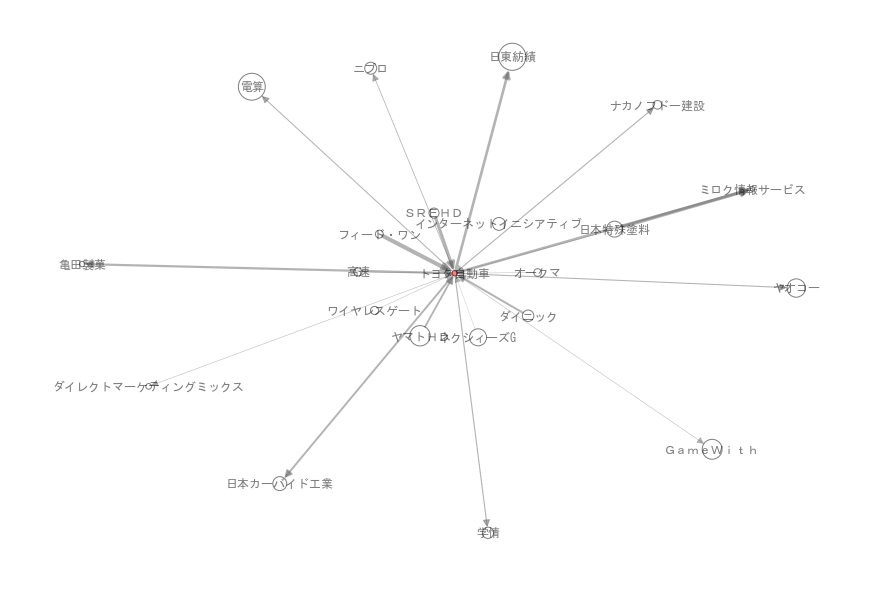

In [6]:
def plot_network(G, alpha, node_scale, node_attr, width_scale, width_attr, arrowsize, seed_for_plot, k_scale):
    fig = plt.figure(figsize = (12, 8))
    # ノードの設定
    edgecolors = "black" # ノードの縁の色(ややこしい)
    node_size = np.sqrt(np.fromiter(nx.get_node_attributes(G, node_attr).values(), dtype = float))*node_scale
    # エッジの設定
    edge_color = "dimgray"
    width = np.fromiter(nx.get_edge_attributes(G, width_attr).values(), dtype = float)*width_scale
    # その他の設定
    pos = nx.spring_layout(G, seed = seed_for_plot, k = k_scale / np.sqrt(G.size()))
    nx.draw(G, with_labels = True, pos = pos,\
        node_size = node_size, node_color = nx.get_node_attributes(G, "COLOR").values(), alpha = alpha, edgecolors = edgecolors, \
        labels = nx.get_node_attributes(G, "NAME"),
        edge_color = edge_color, width = width, arrowsize = arrowsize, font_family = "MS Gothic")

plot_network(G_focus, alpha = 0.5, node_scale = 20, node_attr = "MCAP", \
    width_scale = 15, width_attr = "RATIO_X_TO_Y", arrowsize = 15, \
        seed_for_plot = 300, k_scale = 2.0)

検出されたコミュニティに注目する場合

In [7]:
community = community.greedy_modularity_communities(G_undirected)
print(community[5])

frozenset({8194, 4098, 7173, 3086, 3087, 4114, 3091, 7192, 7198, 7211, 7214, 9265, 4151, 6205, 9279, 5185, 3141, 7238, 7239, 2124, 3148, 3150, 3153, 7250, 3157, 9302, 8279, 8278, 8281, 8282, 3168, 8289, 8291, 2153, 9325, 2157, 3182, 8303, 5233, 4212, 6262, 2168, 2169, 6273, 3202, 2181, 2193, 3221, 8341, 2198, 6293, 8343, 8345, 3228, 8358, 6310, 8360, 9385, 6316, 8366, 7347, 3252, 6328, 4284, 6335, 9414, 9416, 6345, 3275, 9422, 4307, 5332, 7381, 3288, 9432, 4312, 9433, 8411, 9435, 9438, 2267, 6367, 5344, 9449, 9450, 6383, 7408, 4337, 6387, 6390, 3319, 7414, 4344, 9466, 4348, 7421, 9470, 9475, 2307, 3333, 2311, 5393, 1301, 2331, 6428, 4382, 9503, 3360, 4390, 7463, 4392, 6440, 4401, 1332, 2359, 4410, 7483, 3387, 6463, 3392, 7494, 6470, 2376, 6473, 7504, 6482, 7508, 6490, 7514, 5471, 7520, 8544, 1377, 6498, 7524, 5476, 8550, 3431, 6505, 4465, 2418, 5491, 4480, 3458, 7554, 9603, 6532, 7561, 8591, 6547, 8595, 9621, 7575, 3482, 6556, 3484, 9633, 3489, 8613, 2477, 3501, 7601, 7605, 7606, 2492,

In [8]:
node_list = community[5]

In [9]:
# 着目する企業から(方向を考慮しない)距離がdistance以内である企業を(持ち合い以外の場合も)抽出
def filter_neighbors(node):
    distance = 1
    flag = False
    for node_c in node_list:
        flag = (flag | nx.shortest_path_length(G_undirected, source = node_c, target = node) <= distance)
    return flag

G_focus = nx.subgraph_view(G, filter_node = filter_neighbors)
dict_color = dict(zip(node_list, ["red" for _ in range(len(node_list))]))
nx.set_node_attributes(G_focus, name = "COLOR", values = dict_color)

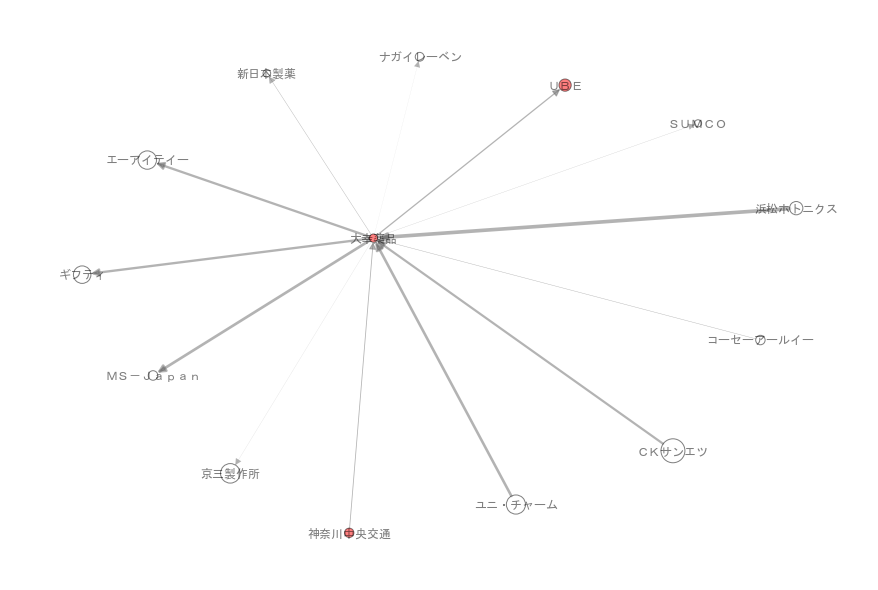

In [10]:
plot_network(G_focus, alpha = 0.5, node_scale = 20, node_attr = "MCAP", \
    width_scale = 15, width_attr = "RATIO_X_TO_Y", arrowsize = 15, \
        seed_for_plot = 300, k_scale = 5.0)

In [12]:
node_list

frozenset({2670,
           2812,
           3627,
           3661,
           4208,
           4574,
           6070,
           6136,
           6856,
           7445,
           7966,
           9081,
           9896})